In [1]:
import os
import shutil
import random

# Path to your dataset (update this)
dataset_dir = "./animals"
output_dir = "dataset"

# Train/Test split ratio
train_ratio = 0.8  # 80% train, 20% test

# Make output folders
for split in ["train", "test"]:
    for category in os.listdir(dataset_dir):
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Split data
for category in os.listdir(dataset_dir):
    files = os.listdir(os.path.join(dataset_dir, category))
    random.shuffle(files)

    total = len(files)
    train_end = int(train_ratio * total)

    train_files = files[:train_end]
    test_files = files[train_end:]

    for f in train_files:
        shutil.copy(os.path.join(dataset_dir, category, f),
                    os.path.join(output_dir, "train", category, f))

    for f in test_files:
        shutil.copy(os.path.join(dataset_dir, category, f),
                    os.path.join(output_dir, "test", category, f))

print("✅ Data split completed! Check the 'split_dataset' folder.")


✅ Data split completed! Check the 'split_dataset' folder.


In [1]:
# ==========================================
# 1. IMPORTS & SETUP
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
data_dir = "./dataset"  
# Image transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
train_data = datasets.ImageFolder(data_dir + "/train", transform=train_transforms)
test_data  = datasets.ImageFolder(data_dir + "/test", transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['cats', 'dogs', 'panda']


In [9]:
import torch
import torchvision.models as models

# 1. Device Selection (Assumes 'device' is set correctly)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Model Initialization
model = models.resnet18(pretrained=True)

# 💥 NEW LINE: Move the model to the selected device 💥
model.to(device)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# The model and its parameters are now on the GPU (if available) or CPU.

Using device: cpu


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

Using device: cpu


C:\Users\admin\.conda\envs\deep\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\.conda\envs\deep\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))  # 3 classes
)
model = model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [12]:
epochs = 5  # Try more epochs if dataset is large
for epoch in range(epochs):
    model.train()
    running_loss, correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    epoch_acc = correct / len(train_data)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

Epoch 1/5, Loss: 0.3211, Acc: 0.8738
Epoch 2/5, Loss: 0.1978, Acc: 0.9247
Epoch 3/5, Loss: 0.1627, Acc: 0.9313
Epoch 4/5, Loss: 0.1528, Acc: 0.9376
Epoch 5/5, Loss: 0.1472, Acc: 0.9435


In [13]:
model.eval()
test_correct, test_loss = 0, 0.0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)

        test_correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_data)
test_acc = test_correct / len(test_data)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")


Test Loss: 0.0508, Test Accuracy: 97.85%


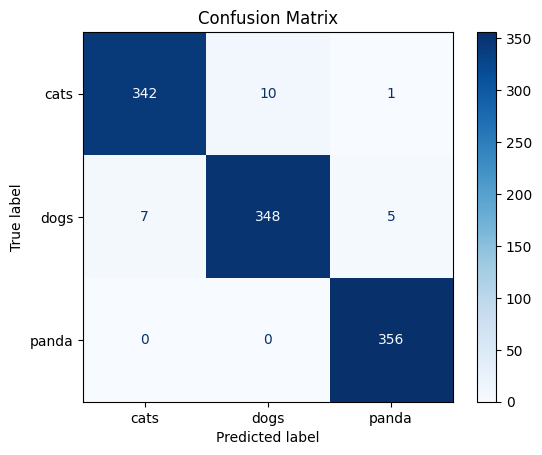

In [14]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [15]:
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = test_transforms
    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)
        prob = torch.softmax(outputs, dim=1)[0][pred].item() * 100

    result = class_names[pred.item()]
    print(f"Prediction: {result} ({prob:.2f}% confidence)")
    return result

In [16]:
# Example usage (make sure this path exists!)
print("\n--- Example Prediction ---")
predict_image("animals\cats\cats_00002.jpg")

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
C:\Users\admin\AppData\Local\Temp\ipykernel_25968\1801683071.py:3: SyntaxWarning: invalid escape sequence '\c'
  predict_image("animals\cats\cats_00002.jpg")



--- Example Prediction ---
Prediction: cats (99.98% confidence)


'cats'